# Patient-specific mapping of fundus photographs to three-dimensional ocular imaging

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helpers import InputOutputAngles

import visisipy

In [2]:
from warnings import filterwarnings

filterwarnings("ignore", category=UserWarning, module="zospy")

In [3]:
# Uncomment the following line to use the Optiland backend
# visisipy.set_backend("optiland")

In [4]:
geometry_parameters = {
    "axial_length": 24.305,  # mm
    "cornea_thickness": 0.5615,  # mm
    "anterior_chamber_depth": 3.345,  # mm
    "lens_thickness": 3.17,  # mm
    "cornea_front_radius": 7.6967,  # mm
    "cornea_front_asphericity": -0.2304,
    "cornea_back_radius": 6.2343,  # mm
    "cornea_back_asphericity": -0.1444,
    "pupil_radius": 0.5,  # mm
    "lens_front_radius": 10.2,  # mm
    "lens_front_asphericity": -3.1316,
    "lens_back_radius": -5.4537,  # mm
    "lens_back_asphericity": -4.1655,
    "retina_radius": -11.3357,  # mm
    "retina_asphericity": -0.0631,
}

geometry: visisipy.models.EyeGeometry = visisipy.models.create_geometry(**geometry_parameters)
model = visisipy.models.EyeModel(geometry=geometry)

In [5]:
field_angles = np.arange(0, 90, 5).astype(float)

raytrace_results = visisipy.analysis.raytrace(
    model, coordinates=zip(len(field_angles) * [0], field_angles, strict=False)
)

In [6]:
# Correct for convention differences: OpticStudio puts the pupil at the origin, Optiland the cornea
# Uncomment the following line to use the Optiland backend
# raytrace_results.z -= geometry.cornea_thickness + geometry.anterior_chamber_depth

In [7]:
raytrace_results

,index,field,wavelength,surface,comment,x,y,z
0,0,"(0.0, 0.0)",0.543,OBJ,NaN,inf,inf,inf
1,1,"(0.0, 0.0)",0.543,1,cornea front,0.0,0.000000,-3.906500
2,2,"(0.0, 0.0)",0.543,2,cornea back / aqueous,0.0,0.000000,-3.345000
3,3,"(0.0, 0.0)",0.543,3,pupil,0.0,0.000000,0.000000
4,4,"(0.0, 0.0)",0.543,4,lens front,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
121,2,"(0.0, 85.0)",0.543,2,cornea back / aqueous,0.0,-5.105036,-0.815929
122,3,"(0.0, 85.0)",0.543,3,pupil Vignetted,0.0,-2.166782,0.000000
123,4,"(0.0, 85.0)",0.543,4,lens front,0.0,-1.677182,0.135958
124,5,"(0.0, 85.0)",0.543,5,lens back / vitreous,0.0,3.555210,2.254460


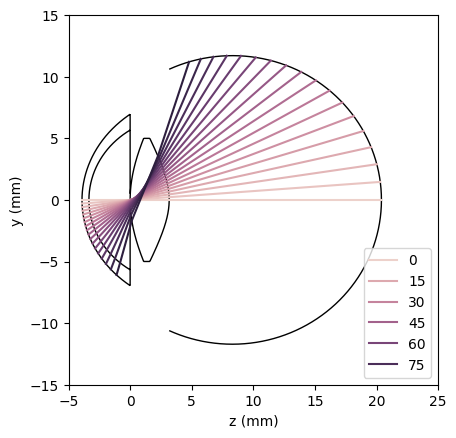

In [8]:
fig, ax = plt.subplots()

visisipy.plots.plot_eye(ax, model, lens_edge_thickness=0.5)
sns.lineplot(
    data=raytrace_results,
    x="z",
    y="y",
    hue=[f[1] for f in raytrace_results.field],
    ax=ax,
)

ax.set_aspect("equal")
ax.set_xlim(-5, 25)
ax.set_ylim(-15, 15)
ax.set_xlabel("z (mm)")
ax.set_ylabel("y (mm)")

sns.move_legend(ax, "lower right")

In [9]:
# Calculate cardinal point locations
cardinal_points = visisipy.analysis.cardinal_points(model)

# Get the location of the second nodal point with respect to the pupil location, which is the origin in OpticStudio
second_nodal_point = cardinal_points.nodal_points.image + (geometry.lens_thickness + geometry.vitreous_thickness)

# In the Navarro model, the second nodal point is located 7.45 mm behind the cornea apex
second_nodal_point_navarro = 7.45 - (geometry.cornea_thickness + geometry.anterior_chamber_depth)

# Calculate the location of the retina center
retina_center = geometry.lens_thickness + geometry.vitreous_thickness + geometry.retina.ellipsoid_radii.z

In [10]:
input_output_angles = pd.DataFrame(
    [
        InputOutputAngles.from_ray_trace_result(
            g.set_index("index"),
            np2=second_nodal_point,
            np2_navarro=second_nodal_point_navarro,
            retina_center=retina_center,
        )
        for _, g in raytrace_results.groupby("field")
    ]
)

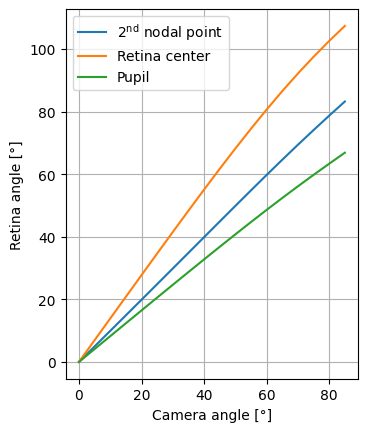

In [11]:
fig, ax = plt.subplots()

sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_np2",
    label="$2^{\\mathrm{nd}}$ nodal point",
)
sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_retina_center",
    label="Retina center",
)
sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_pupil",
    label="Pupil",
)

ax.set_xlabel("Camera angle [°]")
ax.set_ylabel("Retina angle [°]")
ax.set_aspect("equal")
ax.grid()